In [1]:
import pandas as pd
import itertools
import random
import seaborn as sns
import skbio.stats.distance as ssd
from scipy.stats import kruskal
import matplotlib.pyplot as plt

The metadata field 'groups' is used to categorize the probands. 
- G1P is non-NAFLD controls; G1R first degree relatives
- G2P is NAFLD no advanced Fibrosis; G2R first degree relatives
- G3P is NAFLD-cirrhosis; G3R first degree relatives

In [2]:
# load unifrac distance matrix
uwdm = ssd.DistanceMatrix.read('bdiv9k/unweighted_unifrac_dm.txt')
wdm = ssd.DistanceMatrix.read('bdiv9k/unweighted_unifrac_dm.txt')
sample_arr = (wdm.ids)

In [3]:
mapfile = pd.read_table('all_qiime_mapping_complete_corr_CC_28_09.txt', sep='\t', index_col=0)

In [4]:
len(sample_arr)

192

In [5]:
# make pairs of related and unrelated samples
allposs = list(itertools.combinations(sample_arr, 2)) # all possible pairs
rel = []
unrel = []
for pair in allposs:
    if (pair[0].split('.')[-2] == pair[1].split('.')[-2]): # if sample identifiers match
        rel.append(pair)
    else:
        unrel.append(pair)

In [6]:
# GROUP & house INFO
# for related pairs: split into G1s, G2s and G3s

pg1=[]
ph1=[]
pz1=[]

pg2=[]
ph2=[]
pz2=[]

pg3=[]
ph3=[]
pz3=[]

for pair in rel:
    # if any assigned G1 (since they're twins, just one pair per family)
    if 'G1' in str(mapfile.loc[pair[0], 'groups']) or 'G1' in str(mapfile.loc[pair[1], 'groups']):
        pg1.append(pair)
        
        # add housing
        if str(mapfile.loc[pair[0], 'housing']) == '1' and str(mapfile.loc[pair[1], 'housing']) == '1': #to be sure
            ph1.append('shared')
        else:
            ph1.append('not shared')
        
        # add zygoticity    
        if str(mapfile.loc[pair[0], 'zygoticity']) == '1' and str(mapfile.loc[pair[1], 'zygoticity']) == '1': #to be sure
            pz1.append('MZ twins')
        else:
            pz1.append('not MZ twins')
        
    
    # if any assigned G2 (since they're twins, just one pair per family)   
    if 'G2' in str(mapfile.loc[pair[0], 'groups']) or 'G2' in str(mapfile.loc[pair[1], 'groups']):
        pg2.append(pair)
        
        # add housing
        if str(mapfile.loc[pair[0], 'housing']) == '1' and str(mapfile.loc[pair[1], 'housing']) == '1': #to be sure
            ph2.append('shared')
        else:
            ph2.append('not shared')
            
        # add zygoticity    
        if str(mapfile.loc[pair[0], 'zygoticity']) == '1' and str(mapfile.loc[pair[1], 'zygoticity']) == '1': #to be sure
            pz2.append('MZ twins')
        else:
            pz2.append('not MZ twins')
            
    # we make sure each pair contains a proband i.e no relative-relative pairs as there are > 1 relatives for some probands
    if 'G3P' in str(mapfile.loc[pair[0], 'groups']) or 'G3P' in str(mapfile.loc[pair[1], 'groups']):
        pg3.append(pair)
        
        # add housing
        if str(mapfile.loc[pair[0], 'housing']) == '1' and str(mapfile.loc[pair[1], 'housing']) == '1': #to be sure
            ph3.append('shared')
        else:
            ph3.append('not shared')
            
        # add zygoticity    
        if str(mapfile.loc[pair[0], 'zygoticity']) == '1' and str(mapfile.loc[pair[1], 'zygoticity']) == '1': #to be sure
            pz3.append('MZ twins')
        else:
            pz3.append('not MZ twins')
            
# make list of distances belonging to rel, G1, G2, G3, unrel
drel = [uwdm[pair] for pair in rel]
dg1 = [uwdm[pair] for pair in pg1]
dg2 = [uwdm[pair] for pair in pg2]
dg3 = [uwdm[pair] for pair in pg3]
dunrel = [uwdm[pair] for pair in unrel]

# create dataframe used to plot
pdf = pd.DataFrame(index=pd.MultiIndex.from_tuples(pg1+pg2+pg3+unrel), 
                   columns=['unweighted_unifrac','groups', 'housing', 'related', 'zygocity'])

pdf.shape

(18318, 5)

In [7]:
# assign groups
pdf.groups=['G1']*len(pg1)+['G2']*len(pg2)+['G3']*len(pg3)+['unrelated']*len(unrel)
# assign distances
pdf.unweighted_unifrac=dg1+dg2+dg3+dunrel

# assign relatedness
pdf.related = ['related']*len(pg1+pg2+pg3) + ['unrelated']*len(unrel)

#assign housing
pdf.housing = ph1+ph2+ph3 + ['unrelated']*len(unrel)

#assign zygoticity
pdf.zygocity = pz1+pz2+pz3 + ['unrelated']*len(unrel)

In [8]:
#save source data
pdf.reset_index().to_csv('tables/source_data_fig1c_1d.csv')

**For housing, we used a positive filter here i.e 'shared' when both elements have housing=1 & 'not shared'
in all other cases. But some of the unknowns might be shared too. If shared housing pairs are tagged as unshared for ambiguous cases, our estimates will still remain robust as we will be assessing the differences betweeen the groups more conservatively . Therefore, we don't remove these ambiguous pairs to maintain sample size**

### 1. microbiome distance distribution between related and unrelated individuals

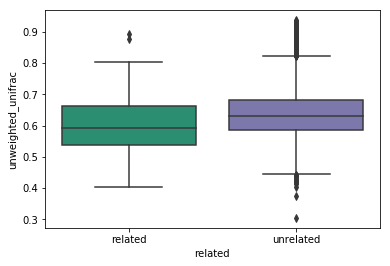

In [9]:
fig, ax = plt.subplots()
sns.boxplot(x='related', y='unweighted_unifrac', data=pdf, ax=ax,
            palette={'related':'#1b9e77','unrelated':'#7570b3'})
plt.savefig('figures/fig1c.1.unwtUF_related_unrelated.pdf', bbox_to_inches='tight')

In [10]:
# related vs. not related
g1 = list(pdf[pdf.related == 'related']['unweighted_unifrac'])
g2 = list(pdf[pdf.related == 'unrelated']['unweighted_unifrac'])
kruskal(g1, g2)

KruskalResult(statistic=17.28162430608063, pvalue=3.2228852279014334e-05)

### 2. microbiome distance between related and unrelated individuals stratified by shared housing

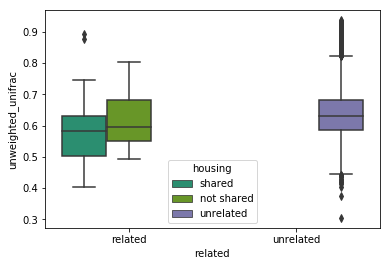

In [11]:
fig, ax = plt.subplots()
sns.boxplot(x='related', y='unweighted_unifrac', hue='housing', data=pdf, 
            palette={'shared':'#1b9e77', 'not shared': '#6ba816', 'unrelated':'#7570b3'})
plt.savefig('figures/fig1d.unwtUF_related_unrelated_housing.pdf', bbox_to_inches='tight')

In [12]:
# shared vs not shared within related individuals
pdfsub =  pdf[pdf.related == 'related']

g1 = list(pdfsub[pdfsub.housing == 'shared']['unweighted_unifrac'])
g2 = list(pdfsub[pdfsub.housing == 'not shared']['unweighted_unifrac'])
print(kruskal(g1, g2))

# not shared vs unrelated 
g3 = list(pdf[pdf.related == 'unrelated']['unweighted_unifrac'])
print(kruskal(g3, g2))
print(kruskal(g1,g3))

KruskalResult(statistic=3.9993238674779832, pvalue=0.045518520277724239)
KruskalResult(statistic=4.7678476500368561, pvalue=0.028996054509472777)
KruskalResult(statistic=15.120690576230118, pvalue=0.00010085186950756731)


### 3. microbiome distance between related and unrelated individuals stratified by MZ status

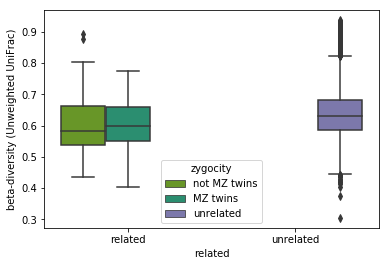

In [13]:
fig, ax = plt.subplots()
ax = sns.boxplot(x='related', y='unweighted_unifrac', hue='zygocity', data=pdf, 
            palette={'MZ twins':'#1b9e77', 'not MZ twins': '#6ba816', 'unrelated':'#7570b3'})
ax.set(ylabel='beta-diversity (Unweighted UniFrac)')
plt.savefig('figures/figS2a.unwtUF_related_unrelated_zygoticity_R1.pdf', bbox_to_inches='tight')

In [14]:
# shared vs not shared within related individuals
pdfsub =  pdf[pdf.related == 'related']

g1 = list(pdfsub[pdfsub.zygocity == 'MZ twins']['unweighted_unifrac'])
g2 = list(pdfsub[pdfsub.zygocity == 'not MZ twins']['unweighted_unifrac'])
print(kruskal(g1, g2))

# not shared vs unrelated 
g3 = list(pdf[pdf.related == 'unrelated']['unweighted_unifrac'])
print(kruskal(g3, g2))
print(kruskal(g1,g3))

KruskalResult(statistic=0.038010175240287936, pvalue=0.84542270879392056)
KruskalResult(statistic=12.828986567663378, pvalue=0.0003412905594502356)
KruskalResult(statistic=4.5061787395170541, pvalue=0.033772611224878742)


### 4. microbiome distance between different disease groups

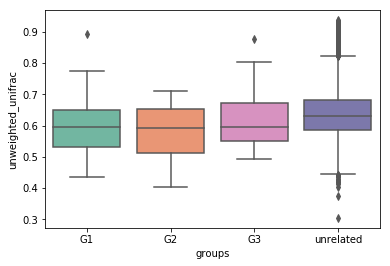

In [15]:
fig, ax = plt.subplots()
sns.boxplot(x='groups', y='unweighted_unifrac', data=pdf,
           palette={'G1':'#66c2a5', 'G2':'#fc8d62', 'G3':'#e287c4', 'unrelated':'#7570b3'})
plt.savefig('figures/fig1c.2.unwtUF_groups_unrelated.pdf', bbox_to_inches='tight')

In [16]:
# kruskal wallis test for shared vs. not shared within related individuals
pdfsub =  pdf[pdf.related == 'related']

g1 = list(pdfsub[pdfsub.groups == 'G1']['unweighted_unifrac'])
g2 = list(pdfsub[pdfsub.groups == 'G2']['unweighted_unifrac'])
g3 = list(pdfsub[pdfsub.groups == 'G3']['unweighted_unifrac'])

g4 = list(pdf[pdf.related == 'unrelated']['unweighted_unifrac'])

print(kruskal(g1, g2))
print(kruskal(g2, g3))
print(kruskal(g1, g3))

print(kruskal(g1, g4))
print(kruskal(g2, g4))
print(kruskal(g3, g4))

KruskalResult(statistic=0.11267056530212471, pvalue=0.73712398150697123)
KruskalResult(statistic=1.6357452071737555, pvalue=0.20091024364769761)
KruskalResult(statistic=1.1994949494949481, pvalue=0.27342264497900259)
KruskalResult(statistic=10.523713867834886, pvalue=0.0011785240270705275)
KruskalResult(statistic=5.84076757333969, pvalue=0.015658994052663192)
KruskalResult(statistic=2.5937310908630025, pvalue=0.1072873340749159)


### 5. microbiome distance between different disease groups stratified by shared housing

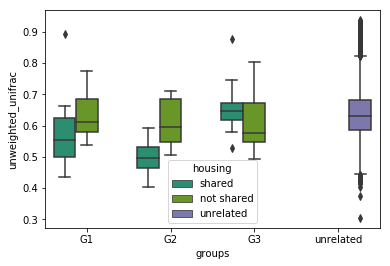

In [17]:
fig, ax = plt.subplots()
sns.boxplot(x='groups', y='unweighted_unifrac', hue='housing', data=pdf,
           palette={'shared':'#1b9e77', 'not shared': '#6ba816', 'unrelated':'#7570b3'})
plt.savefig('figures/unwtUF_groups_unrelated_housing.pdf', bbox_to_inches='tight')

In [18]:
# kruskal wallis test for shared vs. not shared within related individuals
pdfsub =  pdf[pdf.related == 'related']

pdfsubg1 = pdfsub[pdfsub.groups == 'G1']
g1s = list(pdfsubg1[pdfsubg1.housing == 'shared']['unweighted_unifrac'])
g1us = list(pdfsubg1[pdfsubg1.housing == 'not shared']['unweighted_unifrac'])

pdfsubg2 = pdfsub[pdfsub.groups == 'G2']
g2s = list(pdfsubg2[pdfsubg2.housing == 'shared']['unweighted_unifrac'])
g2us = list(pdfsubg2[pdfsubg2.housing == 'not shared']['unweighted_unifrac'])

pdfsubg3 = pdfsub[pdfsub.groups == 'G3']
g3s = list(pdfsubg3[pdfsubg3.housing == 'shared']['unweighted_unifrac'])
g3us = list(pdfsubg3[pdfsubg3.housing == 'not shared']['unweighted_unifrac'])

print(kruskal(g1s, g1us))
print(kruskal(g2s, g2us))
print(kruskal(g3s, g3us))

KruskalResult(statistic=6.1678321678321595, pvalue=0.013009392806716601)
KruskalResult(statistic=4.3636363636363669, pvalue=0.036713856362704092)
KruskalResult(statistic=2.0016339869280984, pvalue=0.15712974084551593)


### 6. microbiome distance between different disease groups stratified by zygoticity

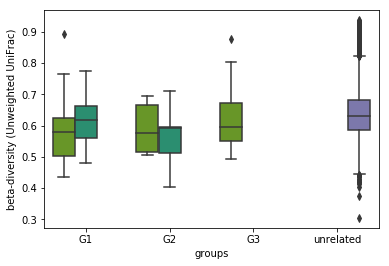

In [19]:
fig, ax = plt.subplots()
sns.boxplot(x='groups', y='unweighted_unifrac', hue='zygocity', data=pdf,
           palette={'MZ twins':'#1b9e77', 'not MZ twins': '#6ba816', 'unrelated': '#7570b3'})
ax.set(ylabel='beta-diversity (Unweighted UniFrac)')
ax.legend_.remove()
plt.savefig('figures/figS2b.unwtUF_groups_unrelated_zygoticity_R1.pdf', bbox_to_inches='tight')

In [20]:
# kruskal wallis test based on genetic similarity within pairs

pdfsub =  pdf[pdf.related == 'related']

pdfsubg1 = pdfsub[pdfsub.groups == 'G1']
g1mz = list(pdfsubg1[pdfsubg1.zygocity == 'MZ twins']['unweighted_unifrac'])
g1nmz = list(pdfsubg1[pdfsubg1.zygocity == 'not MZ twins']['unweighted_unifrac'])

pdfsubg2 = pdfsub[pdfsub.groups == 'G2']
g2mz = list(pdfsubg2[pdfsubg2.zygocity == 'MZ twins']['unweighted_unifrac'])
g2nmz = list(pdfsubg2[pdfsubg2.zygocity == 'not MZ twins']['unweighted_unifrac'])

g4 = list(pdf[pdf.related == 'unrelated']['unweighted_unifrac'])

# Kruskal-wallis between mz and not mz within each group
print(kruskal(g1mz, g1nmz))
print(kruskal(g2mz, g2nmz))

KruskalResult(statistic=2.0139860139860133, pvalue=0.15585536220694751)
KruskalResult(statistic=0.013888888888892836, pvalue=0.90618561575491507)


In [21]:
# Kruskal-wallis to unrelated
print(kruskal(g1mz, g4))
print(kruskal(g1nmz, g4))

print(kruskal(g2mz, g4))
print(kruskal(g2nmz, g4))

KruskalResult(statistic=1.1911116480405326, pvalue=0.27510543835593626)
KruskalResult(statistic=11.120729342481354, pvalue=0.00085368211072522763)
KruskalResult(statistic=4.3432986394473119, pvalue=0.037154872352879814)
KruskalResult(statistic=1.6117289951507701, pvalue=0.20424892889845189)
